## Lesson 8 single object detection on COCO 2017

Download dataset here

http://images.cocodataset.org/zips/train2017.zip

http://images.cocodataset.org/zips/val2017.zip

http://images.cocodataset.org/zips/test2017.zip

http://images.cocodataset.org/annotations/annotations_trainval2017.zip


In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
from fastai.conv_learner import *
from fastai.dataset import *

from pathlib import Path
import json
from PIL import ImageDraw, ImageFont
from matplotlib import patches, patheffects
from scipy.special import expit
torch.cuda.set_device(0)

In [3]:
tqdm.monitor_interval = 0

In [4]:
PATH = Path('data/coco_2017')
list(PATH.iterdir())

[PosixPath('data/coco_2017/coco_annotations2017'),
 PosixPath('data/coco_2017/tmp'),
 PosixPath('data/coco_2017/models'),
 PosixPath('data/coco_2017/coco_train2017')]

In [5]:
trn_j = json.load((PATH/'coco_annotations2017/instances_train2017.json').open())
trn_j.keys()

dict_keys(['info', 'licenses', 'images', 'annotations', 'categories'])

In [6]:
IMAGES,ANNOTATIONS,CATEGORIES = ['images', 'annotations', 'categories']

In [7]:
FILE_NAME,ID,IMG_ID,CAT_ID,BBOX = 'file_name','id','image_id','category_id','bbox'

cats = dict((o[ID], o['name']) for o in trn_j[CATEGORIES])
trn_fns = dict((o[ID], o[FILE_NAME]) for o in trn_j[IMAGES])
trn_ids = [o[ID] for o in trn_j[IMAGES]]

In [8]:
print(len(trn_ids), len(trn_fns))

118287 118287


In [9]:
JPEGS = 'coco_train2017'

In [10]:
IMG_PATH = PATH/JPEGS
list(IMG_PATH.iterdir())[:5]

[PosixPath('data/coco_2017/coco_train2017/000000276209.jpg'),
 PosixPath('data/coco_2017/coco_train2017/000000038083.jpg'),
 PosixPath('data/coco_2017/coco_train2017/000000528643.jpg'),
 PosixPath('data/coco_2017/coco_train2017/000000079274.jpg'),
 PosixPath('data/coco_2017/coco_train2017/000000534881.jpg')]

In [11]:
im0_d = trn_j[IMAGES][0]
im0_d[FILE_NAME],im0_d[ID]

('000000391895.jpg', 391895)

In [12]:
trn_anno = collections.defaultdict(lambda:[])
for o in trn_j[ANNOTATIONS]:
    bb = o[BBOX]
    bb = np.array([bb[1], bb[0], bb[3]+bb[1]-1, bb[2]+bb[0]-1])
    trn_anno[o[IMG_ID]].append((bb,o[CAT_ID]))
        
len(trn_anno)

117266

In [13]:
im_a = trn_anno[im0_d[ID]]; im_a

[(array([146.17, 359.17, 358.74, 470.62]), 4),
 (array([ 22.16, 339.88, 321.89, 492.76]), 1),
 (array([172.82, 471.64, 219.92, 506.56]), 1),
 (array([183.31, 486.01, 217.29, 515.64]), 2)]

In [14]:
im0_a = im_a[0]; im0_a

(array([146.17, 359.17, 358.74, 470.62]), 4)

In [15]:
cats

{1: 'person',
 2: 'bicycle',
 3: 'car',
 4: 'motorcycle',
 5: 'airplane',
 6: 'bus',
 7: 'train',
 8: 'truck',
 9: 'boat',
 10: 'traffic light',
 11: 'fire hydrant',
 13: 'stop sign',
 14: 'parking meter',
 15: 'bench',
 16: 'bird',
 17: 'cat',
 18: 'dog',
 19: 'horse',
 20: 'sheep',
 21: 'cow',
 22: 'elephant',
 23: 'bear',
 24: 'zebra',
 25: 'giraffe',
 27: 'backpack',
 28: 'umbrella',
 31: 'handbag',
 32: 'tie',
 33: 'suitcase',
 34: 'frisbee',
 35: 'skis',
 36: 'snowboard',
 37: 'sports ball',
 38: 'kite',
 39: 'baseball bat',
 40: 'baseball glove',
 41: 'skateboard',
 42: 'surfboard',
 43: 'tennis racket',
 44: 'bottle',
 46: 'wine glass',
 47: 'cup',
 48: 'fork',
 49: 'knife',
 50: 'spoon',
 51: 'bowl',
 52: 'banana',
 53: 'apple',
 54: 'sandwich',
 55: 'orange',
 56: 'broccoli',
 57: 'carrot',
 58: 'hot dog',
 59: 'pizza',
 60: 'donut',
 61: 'cake',
 62: 'chair',
 63: 'couch',
 64: 'potted plant',
 65: 'bed',
 67: 'dining table',
 70: 'toilet',
 72: 'tv',
 73: 'laptop',
 74: 'mo

In [16]:
trn_anno[318219]

[(array([ 38.8 ,  40.65, 639.  , 458.03]), 1),
 (array([  0.  ,   0.  , 630.35, 197.92]), 1),
 (array([436.73, 455.98, 472.09, 513.55]), 74),
 (array([594.41, 405.44, 633.64, 481.03]), 74),
 (array([479.43, 314.26, 568.83, 469.67]), 76),
 (array([241.89, 276.83, 405.9 , 435.2 ]), 76),
 (array([192.18, 329.2 , 239.2 , 396.09]), 74),
 (array([  0.  , 505.24, 308.25, 552.1 ]), 72),
 (array([  0.  , 470.68, 190.86, 515.61]), 72),
 (array([  0.  , 442.51, 118.87, 484.9 ]), 72),
 (array([319.6 , 289.7 , 339.67, 381.2 ]), 74)]

In [17]:
def bb_hw(a): return np.array([a[1],a[0],a[3]-a[1],a[2]-a[0]])

In [18]:
im = open_image(IMG_PATH/im0_d[FILE_NAME])

In [19]:
def show_img(im, figsize=None, ax=None):
    if not ax: fig,ax = plt.subplots(figsize=figsize)
    ax.imshow(im)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    return ax

def draw_outline(o, lw):
    o.set_path_effects([patheffects.Stroke(
        linewidth=lw, foreground='black'), patheffects.Normal()])
    
def draw_rect(ax, b):
    patch = ax.add_patch(patches.Rectangle(b[:2], *b[-2:], fill=False, edgecolor='white', lw=2))
    draw_outline(patch, 4)

def draw_text(ax, xy, txt, sz=14):
    text = ax.text(*xy, txt,
        verticalalignment='top', color='white', fontsize=sz, weight='bold')
    draw_outline(text, 1)

def draw_im(im, ann):
    ax = show_img(im, figsize=(16,8))
    for b,c in ann:
        b = bb_hw(b)
        draw_rect(ax, b)
        draw_text(ax, b[:2], cats[c], sz=16)

def draw_idx(i):
    im_a = trn_anno[i]
    im = open_image(IMG_PATH/trn_fns[i])
    print(im.shape)
    draw_im(im, im_a)

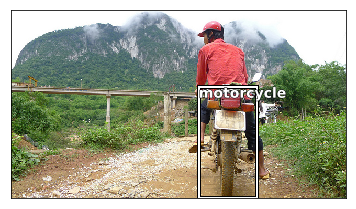

In [20]:
ax = show_img(im)
b = bb_hw(im0_a[0])
draw_rect(ax, b)
draw_text(ax, b[:2], cats[im0_a[1]])

(640, 556, 3)


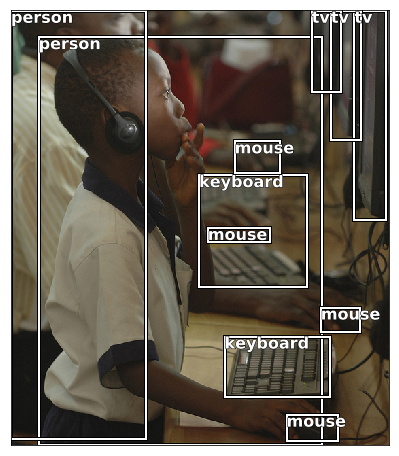

In [21]:
draw_idx(318219)

In [22]:
def get_lrg(b):
    if not b: raise Exception()
    b = sorted(b, key=lambda x: np.product(x[0][-2:]-x[0][:2]), reverse=True)
    return b[0]

In [23]:
trn_lrg_anno = {a: get_lrg(b) for a,b in trn_anno.items()}

In [24]:
for a,b in trn_anno.items():
    if not b: 
        print(a,b)

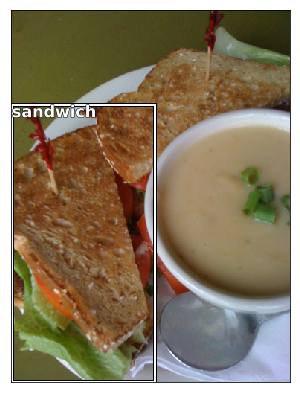

In [25]:
idx=279104

b,c = trn_lrg_anno[idx]
b = bb_hw(b)
ax = show_img(open_image(IMG_PATH/trn_fns[idx]), figsize=(5,10))
draw_rect(ax, b)
draw_text(ax, b[:2], cats[c], sz=16)

In [26]:
for o in list(trn_ids):
    if not trn_anno[o]:        
        print(o)
        trn_ids.remove(o)
        del trn_fns[o]

262284
108169
176649
570045
191501
125997
69911
375363
325690
75083
26767
336777
217005
318596
34089
419106
281582
354041
279103
459408
244636
229782
434129
274233
136173
211423
266091
176149
334642
405104
340781
564317
403104
125084
70125
449546
197774
404462
544597
208708
176193
432647
289943
547760
540388
58133
545235
486632
503200
401623
237860
285068
109942
16903
466935
413120
50637
309571
68715
358795
220739
381842
104880
210766
244160
431026
104829
262189
576017
405945
383450
403279
487702
101623
572546
166524
222330
253520
113185
441863
129988
92604
84018
173685
382115
150616
450098
283147
91372
513149
345711
222757
338067
193704
24499
359184
521098
33554
331600
406217
79331
393212
68838
317130
362986
221828
325357
386613
293671
336873
16689
328084
568863
125182
500079
576354
361831
333198
534918
566025
507686
389811
444302
301765
252101
13789
516542
274957
345063
98268
29056
90280
539390
229981
39068
79913
120235
359465
10263
96923
441788
421673
379190
224970
21382
398454
2731

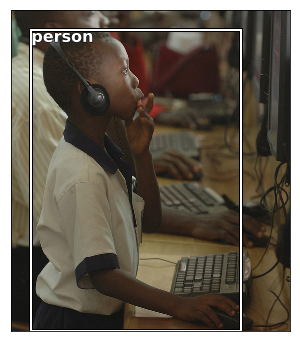

In [27]:
idx=318219

b,c = trn_lrg_anno[idx]
b = bb_hw(b)
ax = show_img(open_image(IMG_PATH/trn_fns[idx]), figsize=(5,10))
draw_rect(ax, b)
draw_text(ax, b[:2], cats[c], sz=16)

In [28]:
(PATH/'tmp').mkdir(exist_ok=True)
CSV = PATH/'tmp/lrg.csv'

In [29]:
for key,value in cats.items():
    if (' ' in value):       
        cats[key]=value.replace(' ','_')
        print(key, value)
    

#for a in trn_ids:
#    print(cats[trn_lrg_anno[a][1]])

## TO DO submit PR fix parse_csv_labels

10 traffic light
11 fire hydrant
13 stop sign
14 parking meter
37 sports ball
39 baseball bat
40 baseball glove
43 tennis racket
46 wine glass
58 hot dog
64 potted plant
67 dining table
77 cell phone
88 teddy bear
89 hair drier


In [30]:
df = pd.DataFrame({'fn': [trn_fns[o] for o in trn_ids],
    'cat': [cats[trn_lrg_anno[o][1]] for o in trn_ids]}, columns=['fn','cat'])
df.to_csv(CSV, index=False)

In [31]:
f_model = resnet34
sz=224
bs=512

In [32]:
tfms = tfms_from_model(f_model, sz, aug_tfms=transforms_side_on, crop_type=CropType.NO)
md = ImageClassifierData.from_csv(PATH, JPEGS, CSV, tfms=tfms)

In [33]:
x,y=next(iter(md.val_dl))

In [34]:
x.shape, y.shape

(torch.Size([64, 3, 224, 224]), torch.Size([64]))

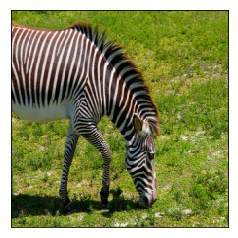

In [35]:
show_img(md.val_ds.denorm(to_np(x))[1]);

In [36]:
learn = ConvLearner.pretrained(f_model, md, metrics=[accuracy])
learn.opt_fn = optim.Adam

In [37]:
lrf=learn.lr_find(1e-5,100)

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

 58%|█████▊    | 844/1466 [03:18<02:26,  4.24it/s, loss=5.84]

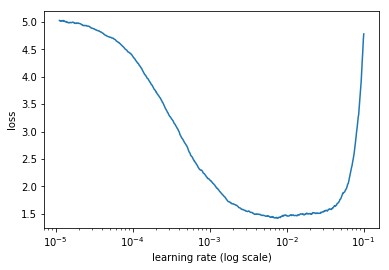

In [38]:
learn.sched.plot()

In [39]:
lr = 2e-3

In [40]:
learn.fit(lr, 1, cycle_len=1)

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

  1%|          | 10/1466 [00:08<20:17,  1.20it/s, loss=5]    


Exception in thread Thread-5:
Traceback (most recent call last):
  File "/home/jopa/anaconda3/envs/fastai/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/home/jopa/anaconda3/envs/fastai/lib/python3.6/site-packages/tqdm/_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "/home/jopa/anaconda3/envs/fastai/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



epoch      trn_loss   val_loss   accuracy                     
    0      1.073939   0.913281   0.733689  



[0.91328067, 0.7336893967614186]

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

 69%|██████▉   | 1011/1466 [04:28<02:01,  3.76it/s, loss=4.4] 

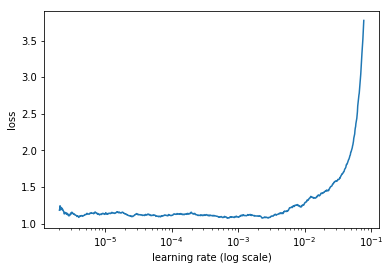

In [41]:
lrs = np.array([lr/1000,lr/100,lr])
learn.freeze_to(-2)
lrf=learn.lr_find(lrs/1000)
learn.sched.plot(1)

In [42]:
learn.fit(lrs/5, 1, cycle_len=1)

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

  1%|          | 9/1466 [00:11<32:17,  1.33s/it, loss=1.15]

Exception in thread Thread-7:
Traceback (most recent call last):
  File "/home/jopa/anaconda3/envs/fastai/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/home/jopa/anaconda3/envs/fastai/lib/python3.6/site-packages/tqdm/_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "/home/jopa/anaconda3/envs/fastai/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



epoch      trn_loss   val_loss   accuracy                      
    0      1.020572   0.877371   0.741149  



[0.8773709, 0.7411488184162317]

In [43]:
learn.unfreeze()

In [44]:
learn.fit(lrs/5, 1, cycle_len=2)

HBox(children=(IntProgress(value=0, description='Epoch', max=2), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                      
    0      0.938529   0.837223   0.752168  
    1      0.894128   0.824833   0.755566                      



[0.8248333, 0.7555655712002954]

In [45]:
learn.save('clas_one')
learn.load('clas_one')

In [46]:
x,y = next(iter(md.val_dl))
probs = F.softmax(predict_batch(learn.model, x), -1)
x,preds = to_np(x),to_np(probs)
preds = np.argmax(preds, -1)

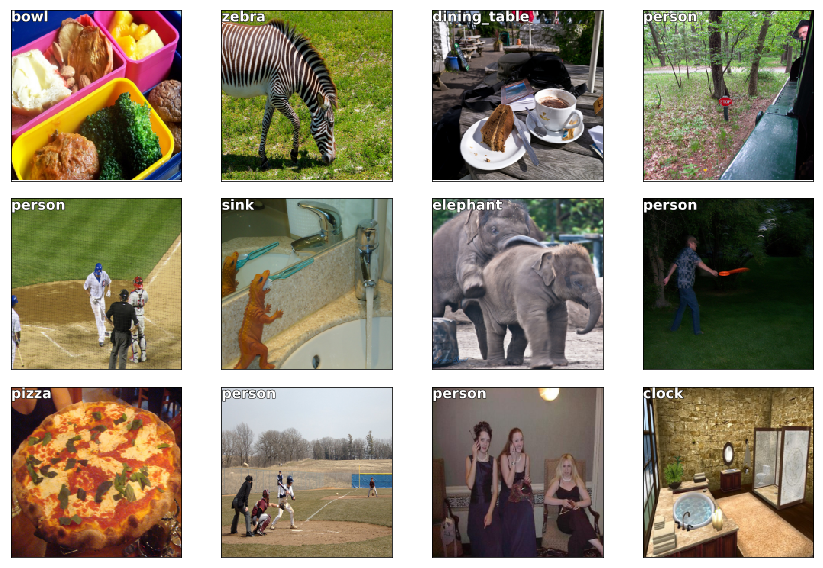

In [47]:
fig, axes = plt.subplots(3, 4, figsize=(12, 8))
for i,ax in enumerate(axes.flat):
    ima=md.val_ds.denorm(x)[i]
    b = md.classes[preds[i]]
    ax = show_img(ima, ax=ax)
    draw_text(ax, (0,0), b)
plt.tight_layout()

### Finding bounding box

In [37]:
BB_CSV = PATH/'tmp/bb.csv'

In [38]:
bb = np.array([trn_lrg_anno[o][0] for o in trn_ids])
bbs = [' '.join(str(p) for p in o) for o in bb]

df = pd.DataFrame({'fn': [trn_fns[o] for o in trn_ids], 'bbox': bbs}, columns=['fn','bbox'])
df.to_csv(BB_CSV, index=False)

In [39]:
BB_CSV.open().readlines()[:5]

['fn,bbox\n',
 '000000391895.jpg,22.16 339.88 321.89000000000004 492.76\n',
 '000000522418.jpg,0.0 382.48 473.31 638.28\n',
 '000000184613.jpg,35.0 0.0 184.0 480.0\n',
 '000000318219.jpg,38.8 40.65 639.0 458.03\n']

In [40]:
f_model=resnet34
sz=224
bs=512
tfms = tfms_from_model(f_model, sz, crop_type=CropType.NO, tfm_y=TfmType.COORD)
md = ImageClassifierData.from_csv(PATH, JPEGS, BB_CSV, tfms=tfms, continuous=True)

In [41]:
x,y=next(iter(md.val_dl))

In [42]:
ima=md.val_ds.denorm(to_np(x))[0]
b = bb_hw(to_np(y[0])); b

array([  1.,  88., 212., 131.], dtype=float32)

In [43]:
head_reg4 = nn.Sequential(Flatten(), nn.Linear(25088,4))
learn = ConvLearner.pretrained(f_model, md, custom_head=head_reg4)
learn.opt_fn = optim.Adam
learn.crit = nn.L1Loss()

In [44]:
learn.summary()

OrderedDict([('Conv2d-1',
              OrderedDict([('input_shape', [-1, 3, 224, 224]),
                           ('output_shape', [-1, 64, 112, 112]),
                           ('trainable', False),
                           ('nb_params', 9408)])),
             ('BatchNorm2d-2',
              OrderedDict([('input_shape', [-1, 64, 112, 112]),
                           ('output_shape', [-1, 64, 112, 112]),
                           ('trainable', False),
                           ('nb_params', 128)])),
             ('ReLU-3',
              OrderedDict([('input_shape', [-1, 64, 112, 112]),
                           ('output_shape', [-1, 64, 112, 112]),
                           ('nb_params', 0)])),
             ('MaxPool2d-4',
              OrderedDict([('input_shape', [-1, 64, 112, 112]),
                           ('output_shape', [-1, 64, 56, 56]),
                           ('nb_params', 0)])),
             ('Conv2d-5',
              OrderedDict([('input_shape', [-1, 64, 56, 

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

 57%|█████▋    | 838/1466 [03:12<02:24,  4.35it/s, loss=121] 

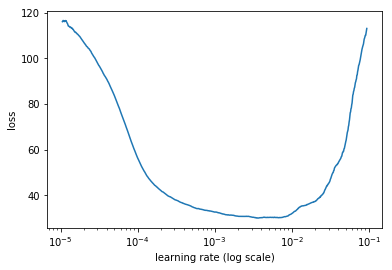

In [56]:
learn.lr_find(1e-5,100)
learn.sched.plot(5)

In [57]:
lr = 2e-4

In [58]:
learn.fit(lr, 2, cycle_len=1, cycle_mult=2)

HBox(children=(IntProgress(value=0, description='Epoch', max=3), HTML(value='')))

  0%|          | 7/1466 [00:06<21:13,  1.15it/s, loss=118]  


Exception in thread Thread-12:
Traceback (most recent call last):
  File "/home/jopa/anaconda3/envs/fastai/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/home/jopa/anaconda3/envs/fastai/lib/python3.6/site-packages/tqdm/_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "/home/jopa/anaconda3/envs/fastai/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



epoch      trn_loss   val_loss                                
    0      29.419654  29.473469 
    1      27.449598  27.451769                               
    2      26.740467  27.237259                               



[27.237259]

In [59]:
lrs = np.array([lr/100,lr/10,lr])

In [60]:
learn.freeze_to(-2)

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

epoch      trn_loss   val_loss                                
    0      92.943377  5436.164062



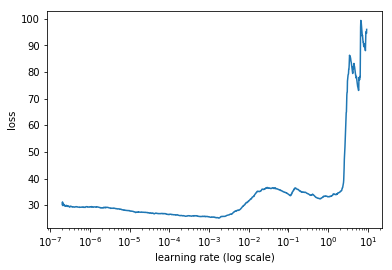

In [61]:
lrf=learn.lr_find(lrs/1000)
learn.sched.plot(1)

In [62]:
learn.fit(lrs, 2, cycle_len=1, cycle_mult=2)

HBox(children=(IntProgress(value=0, description='Epoch', max=3), HTML(value='')))

epoch      trn_loss   val_loss                                
    0      22.478064  22.466637 
    1      20.539141  20.712732                               
    2      18.330842  20.426254                               



[20.426254]

In [63]:
learn.freeze_to(-3)

In [64]:
learn.fit(lrs, 1, cycle_len=2)

HBox(children=(IntProgress(value=0, description='Epoch', max=2), HTML(value='')))

epoch      trn_loss   val_loss                                
    0      18.20371   20.126181 
    1      16.166469  20.039064                               



[20.039064]

In [65]:
learn.save('reg4')
learn.load('reg4')

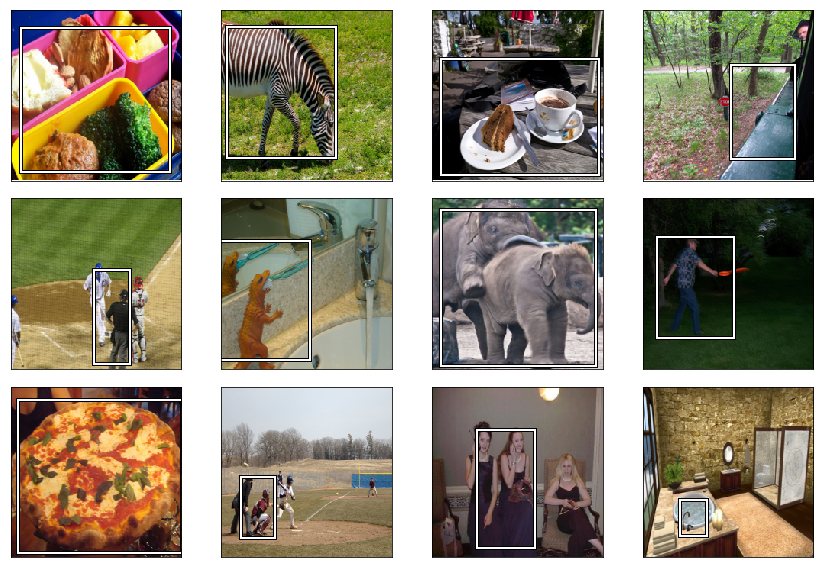

In [66]:
x,y = next(iter(md.val_dl))
learn.model.eval()
preds = to_np(learn.model(VV(x)))

fig, axes = plt.subplots(3, 4, figsize=(12, 8))
for i,ax in enumerate(axes.flat):
    ima=md.val_ds.denorm(to_np(x))[i]
    b = bb_hw(preds[i])
    ax = show_img(ima, ax=ax)
    draw_rect(ax, b)
plt.tight_layout()

### Single object detection

In [45]:
f_model=resnet34 
#f_model=resnext50
sz=224
#sz=299
bs=512

val_idxs = get_cv_idxs(len(trn_fns))

In [46]:
tfms = tfms_from_model(f_model, sz, crop_type=CropType.NO, tfm_y=TfmType.COORD)
md = ImageClassifierData.from_csv(PATH, JPEGS, BB_CSV, tfms=tfms,
    continuous=True, val_idxs=val_idxs)

In [47]:
md2 = ImageClassifierData.from_csv(PATH, JPEGS, CSV, tfms=tfms_from_model(f_model, sz))

In [48]:
learn.summary()

OrderedDict([('Conv2d-1',
              OrderedDict([('input_shape', [-1, 3, 224, 224]),
                           ('output_shape', [-1, 64, 112, 112]),
                           ('trainable', False),
                           ('nb_params', 9408)])),
             ('BatchNorm2d-2',
              OrderedDict([('input_shape', [-1, 64, 112, 112]),
                           ('output_shape', [-1, 64, 112, 112]),
                           ('trainable', False),
                           ('nb_params', 128)])),
             ('ReLU-3',
              OrderedDict([('input_shape', [-1, 64, 112, 112]),
                           ('output_shape', [-1, 64, 112, 112]),
                           ('nb_params', 0)])),
             ('MaxPool2d-4',
              OrderedDict([('input_shape', [-1, 64, 112, 112]),
                           ('output_shape', [-1, 64, 56, 56]),
                           ('nb_params', 0)])),
             ('Conv2d-5',
              OrderedDict([('input_shape', [-1, 64, 56, 

In [49]:
class ConcatLblDataset(Dataset):
    def __init__(self, ds, y2): self.ds,self.y2 = ds,y2
    def __len__(self): return len(self.ds)
    
    def __getitem__(self, i):
        x,y = self.ds[i]
        return (x, (y,self.y2[i]))

In [50]:
trn_ds2 = ConcatLblDataset(md.trn_ds, md2.trn_y)
val_ds2 = ConcatLblDataset(md.val_ds, md2.val_y)

In [51]:
val_ds2[0][1]

(array([ 88.,   1., 219., 213.], dtype=float32), 14)

In [52]:
md.trn_dl.dataset = trn_ds2
md.val_dl.dataset = val_ds2

In [53]:
x,y=next(iter(md.val_dl))

ima=md.val_ds.ds.denorm(to_np(x))[1]
b = bb_hw(to_np(y[0][1])); b

array([  0.,  11., 154., 197.], dtype=float32)

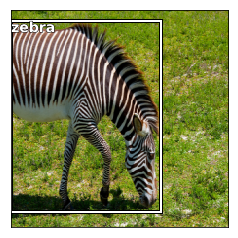

In [54]:
ax = show_img(ima)
draw_rect(ax, b)
draw_text(ax, b[:2], md2.classes[y[1][1]])

In [55]:
head_reg4 = nn.Sequential(
    Flatten(),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(25088,256), 
    nn.ReLU(),
    nn.BatchNorm1d(256),
    nn.Dropout(0.5),
    nn.Linear(256,4+len(cats)),
)
models = ConvnetBuilder(f_model, 0, 0, 0, custom_head=head_reg4)

learn = ConvLearner(md, models)
learn.opt_fn = optim.Adam

In [56]:
def detn_loss(input, target):
    bb_t,c_t = target
    bb_i,c_i = input[:, :4], input[:, 4:]
    bb_i = F.sigmoid(bb_i)*sz
    # I looked at these quantities separately first then picked a multiplier
    #   to make them approximately equal
    return F.l1_loss(bb_i, bb_t) + F.cross_entropy(c_i, c_t)*20

def detn_l1(input, target):
    bb_t,_ = target
    bb_i = input[:, :4]
    bb_i = F.sigmoid(bb_i)*sz
    return F.l1_loss(V(bb_i),V(bb_t)).data

def detn_acc(input, target):
    _,c_t = target
    c_i = input[:, 4:]
    return accuracy(c_i, c_t)

learn.crit = detn_loss
learn.metrics = [detn_acc, detn_l1]

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

 71%|███████▏  | 1046/1466 [03:51<01:32,  4.52it/s, loss=235] 

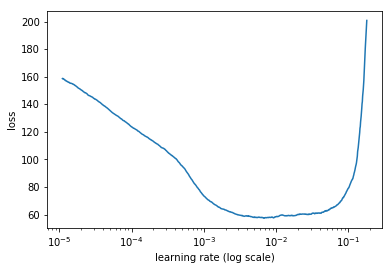

In [79]:
learn.lr_find()
learn.sched.plot()

In [58]:
lr=0.001

In [59]:
#learn.fit(lr, 1)

In [60]:
learn.fit(lr, 2, cycle_len=3, use_clr=(32,5))

HBox(children=(IntProgress(value=0, description='Epoch', max=6), HTML(value='')))

epoch      trn_loss   val_loss   detn_acc   detn_l1           
    0      50.866003  46.097221  0.720943   25.926636 
    1      47.517706  43.365993  0.733154   25.082211         
    2      44.668456  42.353245  0.740774   24.564194         
    3      46.04402   46.921387  0.732728   25.318623         
    4      44.727294  42.453957  0.74017    24.451428         
    5      42.260767  41.851498  0.743329   24.106614         



[41.851498, 0.7433289485991164, 24.106613840004403]

In [61]:
learn.unfreeze()

In [62]:
bs=512

In [63]:
lrs = np.array([lr/1000,lr/100,lr])

In [64]:
learn.fit(lrs, 2, cycle_len=5, use_clr=(32,10))

HBox(children=(IntProgress(value=0, description='Epoch', max=10), HTML(value='')))

epoch      trn_loss   val_loss   detn_acc   detn_l1           
    0      43.954337  40.373421  0.747647   22.881003 
    1      39.673063  39.045025  0.759669   21.993776         
    2      36.629891  38.255798  0.761833   21.503112         
    3      32.957108  38.18055   0.765996   21.279472         
    4      31.25177   38.255978  0.766346   21.088052         
    5      32.864481  40.886528  0.764004   21.271158         
    6      31.345827  41.854343  0.765562   20.945296         
    7      27.991347  40.294769  0.765579   20.764141         
    8      25.592338  42.193787  0.765494   20.671213         
    9      24.386853  41.086063  0.765971   20.610043         



[41.086063, 0.7659714718930403, 20.610042553831512]

In [65]:
learn.save('reg1')

In [66]:
y = learn.predict()
x,_ = next(iter(md.val_dl))

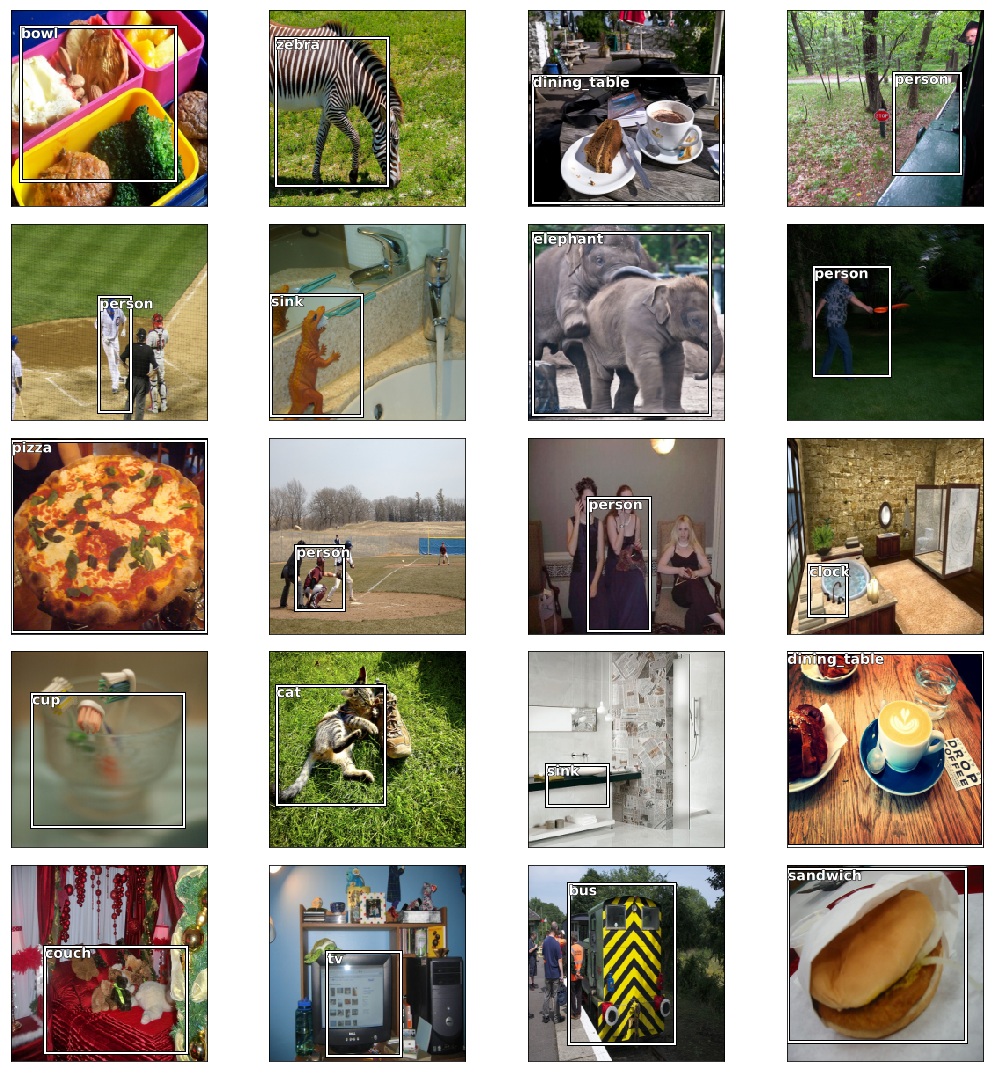

In [68]:
fig, axes = plt.subplots(5, 4, figsize=(15, 15))
for i,ax in enumerate(axes.flat):
    ima=md.val_ds.ds.denorm(to_np(x))[i]
    bb = expit(y[i][:4])*224
    b = bb_hw(bb)
    c = np.argmax(y[i][4:])
    ax = show_img(ima, ax=ax)
    draw_rect(ax, b)
    draw_text(ax, b[:2], md2.classes[c])
plt.tight_layout()